# MRI - Alzheimer Stage Classifier
### by Haim Elbaz & Asaf Levi


## Introduction
The goal of this project is to provide a tool to classify MRI images of alzheimer patients into the different stages of the disease, characterized by dementia severity levels. 

To accomplish this, We will build a CNN model using PyTorch and train it with data obtained from kaggle:

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


## Data Description

## Data Praparation & Preprocessing

The dataset is already split into a train & test sub-sets. 
Within the directories of these sets, the images are arranged in subdirectories named after the class. The image file name indicates an image's unique ID. 

PyTorch's ImageFolder dataset subclass fits exactly this arrangement. 

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from helper import show_images
from torchsummary import summary

In [2]:
TRAINPATH = "Alzheimer_s Dataset/train/"
TESTPATH  = "Alzheimer_s Dataset/train/"

# Making code compatible with either M1, Cuda or CPU
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Chosen device: {device}")

Chosen device: mps


In [3]:
transformer = transforms.Compose([transforms.Resize((208, 176)),
                                transforms.CenterCrop((188, 156)),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAINPATH, transform=transformer)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

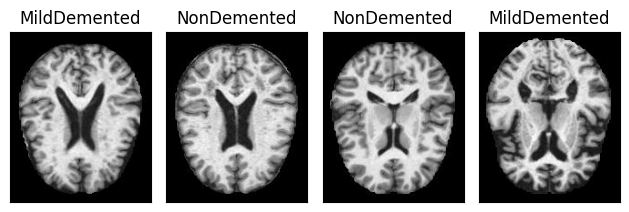

In [5]:
img, labels = next(iter(train_loader))
show_images([img[i] for i in range(4)], labels, idx_to_class)

In [6]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, 3, 2, padding=1)
      self.maxpool1 = nn.MaxPool2d(3, stride=2)
      self.conv2 = nn.Conv2d(32, 46, 38, 2, padding=1)
      self.maxpool2 = nn.MaxPool2d(2, stride=2)
      self.relu1 = nn.ReLU()
      self.flat = nn.Flatten()
      self.fc1 = nn.Linear(138, 69)
      self.fc2 = nn.Linear(69, 4)
        
    def forward(self, x):
      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool2(x)
      x = self.relu1(x)
      x = self.flat(x)
      x = self.fc1(x)
      x = self.fc2(x)
      return x
        

In [7]:

summary(Net(), input_size=(3, 188, 156))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 78]             896
         MaxPool2d-2           [-1, 32, 46, 38]               0
            Conv2d-3             [-1, 46, 6, 2]       2,125,614
         MaxPool2d-4             [-1, 46, 3, 1]               0
              ReLU-5             [-1, 46, 3, 1]               0
           Flatten-6                  [-1, 138]               0
            Linear-7                   [-1, 69]           9,591
            Linear-8                    [-1, 4]             280
Total params: 2,136,381
Trainable params: 2,136,381
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.34
Forward/backward pass size (MB): 2.22
Params size (MB): 8.15
Estimated Total Size (MB): 10.71
----------------------------------------------------------------


In [8]:
MyCNN = Net().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(MyCNN.parameters(), lr=0.001, momentum=0.9)

In [9]:
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = MyCNN(inputs)
        loss = loss_function(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    accuracy = 0
    count = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = MyCNN(inputs)
        accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    accuracy /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, accuracy*100))
 
torch.save(MyCNN.state_dict(), "mri_model.pth")

Epoch 0: model accuracy 46.63%
Epoch 1: model accuracy 56.69%
Epoch 2: model accuracy 59.11%
Epoch 3: model accuracy 61.02%
Epoch 4: model accuracy 69.42%
Epoch 5: model accuracy 70.30%
Epoch 6: model accuracy 63.35%
Epoch 7: model accuracy 85.98%
Epoch 8: model accuracy 88.22%
Epoch 9: model accuracy 83.38%
Epoch 10: model accuracy 97.81%
Epoch 11: model accuracy 98.89%
Epoch 12: model accuracy 99.45%
Epoch 13: model accuracy 98.01%
Epoch 14: model accuracy 99.65%
Epoch 15: model accuracy 99.84%
Epoch 16: model accuracy 100.00%
